<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение моделей</a></span></li><li><span><a href="#Анализ-моделей" data-toc-modified-id="Анализ-моделей-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Анализ моделей</a></span></li><li><span><a href="#Тестирование-лучшей-модели" data-toc-modified-id="Тестирование-лучшей-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование лучшей модели</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общий вывод</a></span></li></ul></div>

# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Нам нужно построить модель для определения стоимости.

*Заказчику важны*:

- качество предсказания;
- скорость предсказания;
- время обучения.

**Описание данных**

Данные находятся в файле `autos.csv`


**Признаки:**

- *DateCrawled* — дата скачивания анкеты из базы
- *VehicleType* — тип автомобильного кузова
- *RegistrationYear* — год регистрации автомобиля
- *Gearbox* — тип коробки передач
- *Power* — мощность (л. с.)
- *Model* — модель автомобиля
- *Kilometer* — пробег (км)
- *RegistrationMonth* — месяц регистрации автомобиля
- *FuelType* — тип топлива
- *Brand* — марка автомобиля
- *Repaired* — была машина в ремонте или нет
- *DateCreated* — дата создания анкеты
- *NumberOfPictures* — количество фотографий автомобиля
- *PostalCode* — почтовый индекс владельца анкеты (пользователя)
- *LastSeen* — дата последней активности пользователя

---

*Целевой признак* --> **Price — цена (евро)**

## Подготовка данных

Начнем с импорта библиотек

In [1]:
# импорты из стандартной библиотеки
import re
import warnings

# импорты сторонних библиотек
import pandas as pd
import numpy as np
import lightgbm as lgb

# импорты модулей текущего проекта
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.compose import make_column_transformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import (
    GridSearchCV, 
    RandomizedSearchCV,
    train_test_split,
    cross_validate
)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler
)
# настройки
warnings.filterwarnings("ignore")

# константы заглавными буквами
RANDOM_STATE = 12345

Прочитаем файл `autos.csv` и присвоим его переменной `autos` 

In [2]:
try:
    autos = pd.read_csv('autos.csv')
except:
    autos = pd.read_csv('/datasets/autos.csv')

In [3]:
autos.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [4]:
autos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [5]:
# есть пропуски
autos.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

In [6]:
autos.describe(include='all')

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
count,354369,354369.000000,316879,354369.000000,334536,354369.000000,334664,354369.000000,354369.000000,321474,354369,283215,354369,354369.0,354369.000000,354369
unique,271174,NaN,8,NaN,2,NaN,250,NaN,NaN,7,40,2,109,NaN,NaN,179150
top,2016-03-24 14:49:47,NaN,sedan,NaN,manual,NaN,golf,NaN,NaN,petrol,volkswagen,no,2016-04-03 00:00:00,NaN,NaN,2016-04-06 13:45:54
freq,7,NaN,91457,NaN,268251,NaN,29232,NaN,NaN,216352,77013,247161,13719,NaN,NaN,17
mean,NaN,4416.656776,NaN,2004.234448,NaN,110.094337,NaN,128211.172535,5.714645,NaN,NaN,NaN,NaN,0.0,50508.689087,NaN
std,NaN,4514.158514,NaN,90.227958,NaN,189.850405,NaN,37905.341530,3.726421,NaN,NaN,NaN,NaN,0.0,25783.096248,NaN
min,NaN,0.000000,NaN,1000.000000,NaN,0.000000,NaN,5000.000000,0.000000,NaN,NaN,NaN,NaN,0.0,1067.000000,NaN
25%,NaN,1050.000000,NaN,1999.000000,NaN,69.000000,NaN,125000.000000,3.000000,NaN,NaN,NaN,NaN,0.0,30165.000000,NaN
50%,NaN,2700.000000,NaN,2003.000000,NaN,105.000000,NaN,150000.000000,6.000000,NaN,NaN,NaN,NaN,0.0,49413.000000,NaN
75%,NaN,6400.000000,NaN,2008.000000,NaN,143.000000,NaN,150000.000000,9.000000,NaN,NaN,NaN,NaN,0.0,71083.000000,NaN


1. Нужно будет поработать над названиями признаков --> перевести их в snake_case
2. Также, посмотреть на Dtype столбцов, может, можно будет что-то перевести в int/float
3. Заполнить пропуски / удалить строки
4. Проверить есть ли дубликаты

Приведем названия признаков к snake_case.

Воспользуемся библиотекой re, функцией map и lambda

In [7]:
autos.columns = map(lambda column: re.sub(r'(?<!^)(?=[A-Z])', '_', column).lower(), autos.columns)

autos.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

In [8]:
autos.head()

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Столбцы `date_crawled`, `date_created` и `last_seen` приведем к типу **datetime**

In [9]:
autos['date_crawled'] = pd.to_datetime(autos['date_crawled'], format='%Y-%m-%d %H:%M:%S')
autos['date_created'] = pd.to_datetime(autos['date_created'], format='%Y-%m-%d %H:%M:%S')
autos['last_seen'] = pd.to_datetime(autos['last_seen'], format='%Y-%m-%d %H:%M:%S')

In [10]:
# ок
autos[['date_crawled', 'date_created', 'last_seen']].dtypes

date_crawled    datetime64[ns]
date_created    datetime64[ns]
last_seen       datetime64[ns]
dtype: object

Удалим явные дубликаты с помощью `duplicated`

In [11]:
autos = autos[~autos.duplicated()].reset_index(drop=True)
autos.shape[0]

354365

Посмотрим на пропуски и подумаем что с ними делать

In [12]:
autos.vehicle_type.value_counts(dropna=False)

sedan          91457
small          79830
wagon          65165
NaN            37490
bus            28775
convertible    20203
coupe          16161
suv            11996
other           3288
Name: vehicle_type, dtype: int64

Как видим, пропусков довольно много, можно попробовать заполнить их средним значением по бренду (признак `brand`)

In [13]:
def fill_autos_feature(feature: pd.Series):
    """Функция заполняет пропуски столбца, переданного ей в аргумент, для датасета autos.

    Args:
        feature (pd.Series): столбец, для которого нужно заполнить пропуски
    """
    # создается сгруппированный brand и feature датасет
    # для каждого бренда подсчитывается value_counts по feature
    autos_grouped = autos.groupby(['brand', feature])[feature].agg('count')
    
    # подготавливается dict
    brand_dict = {}
    
    # dict заполняется значениями: 'значение brand': 'значение feature для этого brand с наибольшим количеством вхождений'
    # сложно описал извините..
    for brand in autos.brand.unique():
        try:
            sub_df = autos_grouped[brand].sort_values(ascending=False)
            brand_dict[brand] = sub_df.index[0]
        except:
            continue
            
    # создается pd.Series где значения brand из датасета autos заменены на значения feature из brand_dict
    popular_stuff = autos['brand'].map(brand_dict)
    
    # autos[feature] заполняется нужными значениями
    autos[feature] = autos[feature].fillna(popular_stuff)

Применим нашу функцию для фичей с пропусками, тем самым заполним пропуски в них.

In [14]:
features_to_fill = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'repaired']

for feature in features_to_fill:
    fill_autos_feature(feature)

Для машин бренда sonstige_autos модели не указаны впринципе, заполним значения вручную. 

In [15]:
autos.loc[autos['brand'] == 'sonstige_autos', 'model'] = 'other'

Признак `repaired` приведем к типу int, yes/no --> 1, 0

In [16]:
autos.loc[autos['repaired'] == 'yes', 'repaired'] = 1
autos.loc[autos['repaired'] == 'no', 'repaired'] = 0

autos['repaired'] = autos['repaired'].astype('int')

In [17]:
autos['repaired'].dtype

dtype('int32')

Посмотрим, есть ли выбросы

In [18]:
autos.describe()

,price,registration_year,power,kilometer,registration_month,repaired,number_of_pictures,postal_code
count,354365.000000,354365.000000,354365.000000,354365.000000,354365.000000,354365.000000,354365.0,354365.000000
mean,4416.679830,2004.234481,110.093816,128211.363989,5.714650,0.101740,0.0,50508.503800
std,4514.176349,90.228466,189.851330,37905.083858,3.726432,0.302306,0.0,25783.100078
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,1.000000,0.0,99998.000000


registration_year и power выглядят подозрительно, также, месяц в столбце registration_month не может быть нулевым. Price, вряд ли тоже может быть нулевым.

In [19]:
autos['registration_year'].sort_values().head(70)

66198     1000
183778    1000
323440    1000
174892    1000
97736     1000
          ... 
195854    1800
321779    1910
133623    1910
58883     1910
269600    1910
Name: registration_year, Length: 70, dtype: int64

In [20]:
autos['registration_year'].sort_values(ascending=False).head(100)

151228    9999
326721    9999
167937    9999
306575    9999
333484    9999
          ... 
172241    2800
122692    2500
328449    2500
317852    2500
139756    2500
Name: registration_year, Length: 100, dtype: int64

Будем считать, что 1910 год - это трешхолд для нижней планки, а 2023 год - трешхолд для верхней планки.

<AxesSubplot:ylabel='Frequency'>

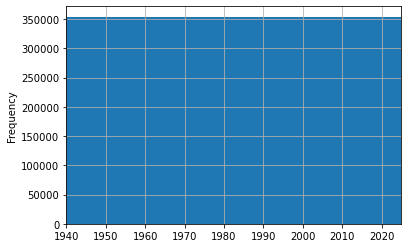

In [21]:
autos.registration_year.plot(kind='hist', grid=True, xlim=(1940, 2025), bins=25)

Недостаточно, попробуем установить нижний трешхолд равным 1950, а верхний - 2016.

P.S. по какой-то неведомой мне причине, если запустить ячейку с этим графиком в первый раз то он будет вот такой))
А если во второй то уже все норм.

In [22]:
autos = autos.query('registration_year >= 1950 and registration_year <= 2016').reset_index(drop=True)

autos['power'] = autos['power'].astype('int')

Ок, посмотрим теперь на power

In [23]:
autos.power.sort_values().head(50000)

0          0
249782     0
249768     0
249766     0
249755     0
          ..
307224    54
76767     54
298868    54
149637    54
278295    54
Name: power, Length: 50000, dtype: int32

In [24]:
autos.power.sort_values(ascending=False).head(330)

210479    20000
286746    19312
109438    19211
127076    19208
61317     17932
          ...  
79702       671
167036      651
338877      650
203283      650
238851      645
Name: power, Length: 330, dtype: int32

<AxesSubplot:ylabel='Frequency'>

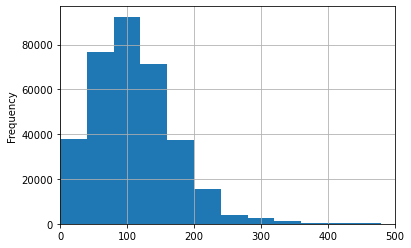

In [25]:
autos.power.plot(kind='hist', grid=True, bins=500, xlim=(0, 500))

Для power положим, что 800 л.с. будет хорошим порогом.

Не уверен, что делать со значениями power = 0, им очень много.. пусть это будет означать, что значение неизвестно.

In [26]:
autos = autos.query('power < 800').reset_index(drop=True)

autos['registration_year'] = autos['registration_year'].astype('int')

<AxesSubplot:ylabel='Frequency'>

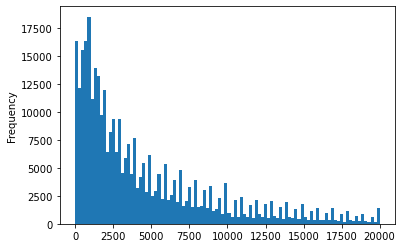

In [27]:
autos.price.plot(kind='hist', bins=100)

In [28]:
autos.price.sort_values().head(7500)

313102    0
269828    0
252031    0
9987      0
291179    0
         ..
30277     0
310142    0
37961     0
68415     0
69252     0
Name: price, Length: 7500, dtype: int64

In [29]:
autos = autos.query('price > 200').reset_index(drop=True)

autos['price'] = autos['price'].astype('int')

In [30]:
autos[autos['registration_month'] == 0].shape[0]

26048

Значений 0 в registration_month также очнь много, положим, что это значит "Неизвестно". Подскажи, как будет правильно с ними поступить?

Также заметим, что number_of_pictures и registration_month совершенно неинформативены, удалим признаки

In [31]:
autos = autos.drop(['number_of_pictures', 'registration_month'], axis=1)

In [32]:
autos.describe()

,price,registration_year,power,kilometer,repaired,postal_code
count,320933.000000,320933.000000,320933.000000,320933.000000,320933.000000,320933.000000
mean,4725.522869,2002.724213,110.178224,128309.771822,0.094166,50867.030676
std,4546.203550,6.703279,62.446456,37148.597663,0.292060,25727.223776
min,202.000000,1950.000000,0.000000,5000.000000,0.000000,1067.000000
25%,1300.000000,1999.000000,75.000000,125000.000000,0.000000,30627.000000
50%,2999.000000,2003.000000,105.000000,150000.000000,0.000000,49699.000000
75%,6800.000000,2007.000000,143.000000,150000.000000,0.000000,71384.000000
max,20000.000000,2016.000000,776.000000,150000.000000,1.000000,99998.000000


In [33]:
autos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320933 entries, 0 to 320932
Data columns (total 14 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   date_crawled       320933 non-null  datetime64[ns]
 1   price              320933 non-null  int32         
 2   vehicle_type       320933 non-null  object        
 3   registration_year  320933 non-null  int32         
 4   gearbox            320933 non-null  object        
 5   power              320933 non-null  int32         
 6   model              320933 non-null  object        
 7   kilometer          320933 non-null  int64         
 8   fuel_type          320933 non-null  object        
 9   brand              320933 non-null  object        
 10  repaired           320933 non-null  int32         
 11  date_created       320933 non-null  datetime64[ns]
 12  postal_code        320933 non-null  int64         
 13  last_seen          320933 non-null  datetime

**`Промежуточный вывод`:**

- данные загружены и изучены
- названия признаков переведены в snake_case
- изменены Dtype столбцов
- заполнены пропуски
- удалены строки с аномалиями
- удалены дубликаты

## Обучение моделей

Подготовим выборки, для этого воспользуемся методом train_test_split

In [34]:
X = autos.drop(['price', 'date_crawled', 'date_created', 'last_seen'], axis=1)
y = autos['price']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=RANDOM_STATE
)

In [35]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 240699 entries, 197785 to 217570
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   vehicle_type       240699 non-null  object
 1   registration_year  240699 non-null  int32 
 2   gearbox            240699 non-null  object
 3   power              240699 non-null  int32 
 4   model              240699 non-null  object
 5   kilometer          240699 non-null  int64 
 6   fuel_type          240699 non-null  object
 7   brand              240699 non-null  object
 8   repaired           240699 non-null  int32 
 9   postal_code        240699 non-null  int64 
dtypes: int32(3), int64(2), object(5)
memory usage: 17.4+ MB


In [36]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 80234 entries, 53923 to 156850
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   vehicle_type       80234 non-null  object
 1   registration_year  80234 non-null  int32 
 2   gearbox            80234 non-null  object
 3   power              80234 non-null  int32 
 4   model              80234 non-null  object
 5   kilometer          80234 non-null  int64 
 6   fuel_type          80234 non-null  object
 7   brand              80234 non-null  object
 8   repaired           80234 non-null  int32 
 9   postal_code        80234 non-null  int64 
dtypes: int32(3), int64(2), object(5)
memory usage: 5.8+ MB


В качестве первой модели попробуем LinearRegression, Ridge и LGBMRegressor. Будем использовать OHE кодирование категориальных признаков и StandardScaler для численных признаков.

In [37]:
#категориальные признаки для OHE LinearRegression
ohe_features_lr = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand']
ohe_features_lr

['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand']

In [38]:
# численные признаки
num_features = ['registration_year', 'power', 'kilometer', 'postal_code']
num_features

['registration_year', 'power', 'kilometer', 'postal_code']

In [39]:
X_train_lr = X_train.copy()
X_test_lr = X_test.copy()

Приступим к кодировке:

- с помощью drop='first' обойдем dummy-ловушку
- handle_unknown='ignore' позволит игнорировать ранее невстречающиеся значения признака (при transform)

In [40]:
# создаем энкодер
encoder_ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)

# обучаем энкодер на заданных категориальных признаках тренировочной выборки
encoder_ohe.fit(X_train_lr[ohe_features_lr])

# добавляем закодированные признаки в X_train_ohe
# encoder_ohe.get_feature_names_out() позволяет получить названия колонок
X_train_lr[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(X_train_lr[ohe_features_lr])

# удаляем незакодированные категориальные признаки
X_train_lr = X_train_lr.drop(ohe_features_lr, axis=1)

# создаём скелер
scaler = StandardScaler()

# обучаем его на численных признаках тренировочной выборки, трансформируем её же
X_train_lr[num_features] = scaler.fit_transform(X_train_lr[num_features])

# смотрим на результат
X_train_lr.head()

,registration_year,power,kilometer,repaired,postal_code,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_other,vehicle_type_sedan,vehicle_type_small,...,brand_seat,brand_skoda,brand_smart,brand_sonstige_autos,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo
197785,1.083582,1.503991,0.583952,0,-0.595619,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
59552,-0.556486,-0.804875,0.583952,0,-0.083499,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
227400,0.039902,0.237321,-1.030022,0,1.895434,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
263004,-0.258292,1.503991,0.583952,0,0.208364,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11219,-0.854680,-0.147490,0.583952,1,-0.776479,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


Буду пробовать линейные модели, поэтому сразу закодируем и тестовую выборку.

P.S. можно использовать вместе с пайплайном

In [41]:
# энкодером, который обучен на ТРЕНИРОВОЧНОЙ ВЫБОРКЕ, кодируем тестовую
X_test_lr[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(X_test_lr[ohe_features_lr])

X_test_lr = X_test_lr.drop(ohe_features_lr, axis=1)

# скелером, который обучен на ТРЕНИРОВОЧНОЙ ВЫБОРКЕ, масштабируем тестовую
X_test_lr[num_features] = scaler.transform(
    X_test_lr[num_features]
)

# смотрим на результат
X_test_lr.head()

,registration_year,power,kilometer,repaired,postal_code,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_other,vehicle_type_sedan,vehicle_type_small,...,brand_seat,brand_skoda,brand_smart,brand_sonstige_autos,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo
53923,-0.258292,1.936903,0.583952,0,-0.189295,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
84869,-0.109195,-0.083355,0.583952,1,0.339959,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
235582,1.232679,0.413693,-0.761026,0,-1.148845,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
270676,0.785388,-1.766903,0.583952,0,-1.447157,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
87444,0.039902,-0.323862,0.583952,0,-0.052183,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [42]:
%%time

# инициализируем модель
lr_model = LinearRegression()

# используем cross_validate, получим оценку на кросс-валидации, время фита и время предикта
lr_cv_summary = cross_validate(
    lr_model, X_train_lr, y_train, scoring="neg_root_mean_squared_error", cv=5
)

# вытаскиваем информацию о времени
lr_cross_val_rmse = lr_cv_summary['test_score'].sum() / -5
lr_fit_time = lr_cv_summary['fit_time'].sum() / 5
lr_predict_time = lr_cv_summary['score_time'].sum() / 5

# выводим информацию на экран
print(f'LR CROSS VAL RMSE: {lr_cross_val_rmse:.3f}')
print(f'LR FIT TIME: {lr_fit_time:.3f}')
print(f'LR PREDICT TIME: {lr_predict_time:.3f}')
print('--------------------------')

LR CROSS VAL RMSE: 2723.181
LR FIT TIME: 3.472
LR PREDICT TIME: 0.068
--------------------------
Wall time: 18 s


Попробуем теперь RidgeRegression


Т.к. все параметры для LR мы преобразовали, просто обучим Ridge и посмотрим на результаты:

In [43]:
%%time

# создаем модель
model_ridge = Ridge(random_state=RANDOM_STATE)

# словарь с гиперпараметрами и значениями, которые хотим перебрать
param_grid_ridge = {
    'alpha': np.arange(0, 0.21, 0.01),
}

# инициализируем gs
gs_ridge = GridSearchCV(
    model_ridge, 
    param_grid=param_grid_ridge, 
    scoring='neg_root_mean_squared_error'
)

# фиттим gs
gs_ridge.fit(X_train_lr, y_train)

# вытаскиваем информацию о времени из cv_results_ (21 т.к. столько раз gs перебирал параметр alpha)
ridge_fit_time = gs_ridge.cv_results_['mean_fit_time'].sum() / 21
ridge_predict_time = gs_ridge.cv_results_['mean_score_time'].sum() / 21

# выводим нужные значения на экран
print(f'RIDGE CROSS VAL RMSE: {gs_ridge.best_score_ * -1:.3f}')
print(f'BEST PARAMS: {gs_ridge.best_params_}')
print(f'LR FIT TIME: {ridge_fit_time:.3f}')
print(f'LR PREDICT TIME: {ridge_predict_time:.3f}')
print('--------------------------')

RIDGE CROSS VAL RMSE: 2723.140
BEST PARAMS: {'alpha': 0.2}
LR FIT TIME: 1.234
LR PREDICT TIME: 0.067
--------------------------
Wall time: 2min 23s


Время пробовать LGBMRegressor, для начала без подбора гиперпараметров

In [44]:
%%time

# инициализируем модель
lgbm_model = lgb.LGBMRegressor(random_state=RANDOM_STATE, n_jobs=-1)

# используем cross_validate, получим оценку на кросс-валидации, время фита и время предикта
lgbm_cv_summary = cross_validate(
    lgbm_model, X_train_lr, y_train, scoring="neg_root_mean_squared_error", cv=5
)

# вытаскиваем информацию о времени
lgbm_cross_val_rmse = lgbm_cv_summary['test_score'].sum() / -5
lgbm_fit_time = lgbm_cv_summary['fit_time'].sum() / 5
lgbm_predict_time = lgbm_cv_summary['score_time'].sum() / 5

# выводим информацию на экран
print(f'LGBM REGRESSOR CROSS VAL RMSE: {lgbm_cross_val_rmse:.3f}')
print(f'LGBM REGRESSOR FIT TIME: {lgbm_fit_time:.3f}')
print(f'LGBM REGRESSOR PREDICT TIME: {lgbm_predict_time:.3f}')
print('--------------------------')

LGBM REGRESSOR CROSS VAL RMSE: 1712.980
LGBM REGRESSOR FIT TIME: 1.756
LGBM REGRESSOR PREDICT TIME: 0.216
--------------------------
Wall time: 10.2 s


Попробуем теперь обучить lgbm с подбором параметров в GridSearchCV

In [45]:
%%time

# словарь с гиперпараметрами и значениями, которые хотим перебрать
param_grid_lgbm = {
    'max_depth': np.arange(5, 10, 1),
    'learning_rate': np.arange(0.1, 0.5, 0.1),
    'n_estimators': np.arange(130, 160, 20)
}

# инициализируем gs
gs_lgbm = GridSearchCV(
    lgbm_model, 
    param_grid=param_grid_lgbm, 
    scoring='neg_root_mean_squared_error'
)

# фиттим gs
gs_lgbm.fit(X_train_lr, y_train)

# вытаскиваем информацию о времени из cv_results_
gs_lgbm_fit_time = gs_lgbm.cv_results_['mean_fit_time'].sum() / len(gs_lgbm.cv_results_['mean_fit_time'])
gs_lgbm_predict_time = gs_lgbm.cv_results_['mean_score_time'].sum() / len(gs_lgbm.cv_results_['mean_score_time'])

# выводим нужные значения на экран
print(f'LGBM REGRESSOR CROSS VAL RMSE: {gs_lgbm.best_score_ * -1:.3f}')
print(f'LGBM REGRESSOR BEST PARAMS: {gs_lgbm.best_params_}')
print(f'LGBM REGRESSOR FIT TIME: {gs_lgbm_fit_time:.3f}')
print(f'LGBM REGRESSOR PREDICT TIME: {gs_lgbm_predict_time:.3f}')
print('--------------------------')

LGBM REGRESSOR CROSS VAL RMSE: 1633.194
LGBM REGRESSOR BEST PARAMS: {'learning_rate': 0.4, 'max_depth': 9, 'n_estimators': 150}
LGBM REGRESSOR FIT TIME: 1.736
LGBM REGRESSOR PREDICT TIME: 0.231
--------------------------
Wall time: 6min 47s


**`Промежуточный вывод`:**

- подготовлены выборки, для этого воспользовались методом train_test_split
- проведено OHE кодирование категориальных признаков
- проведено кодирование численных признаков с помощью StandardScaler
- обучены модели LinearRegression, Ridge и LGBMRegressor

## Анализ моделей

**`Вывод из обучения моделей`:**

1. LinearRegression без подбора гиперпараметров:

- LR CROSS VAL RMSE: 2723.181
- LR FIT TIME: 3.472
- LR PREDICT TIME: 0.068
- Wall time: 18 s

2. Ridge с подбором гиперпараметров в GridSearchCV:

- RIDGE CROSS VAL RMSE: 2723.140
- BEST PARAMS: {'alpha': 0.2}
- LR FIT TIME: 1.234
- LR PREDICT TIME: 0.067
- Wall time: 2min 23s

3. LGBMRegressor без подбора гиперпараметров:

- LGBM REGRESSOR CROSS VAL RMSE: 1712.980
- LGBM REGRESSOR FIT TIME: 1.756
- LGBM REGRESSOR PREDICT TIME: 0.216
- Wall time: 10.2 s

4. LGBMRegressor с подбором гиперпараметров в GridSearchCV:

- LGBM REGRESSOR CROSS VAL RMSE: 1633.194
- LGBM REGRESSOR BEST PARAMS: {'learning_rate': 0.4, 'max_depth': 9, 'n_estimators': 150}
- LGBM REGRESSOR FIT TIME: 1.736
- LGBM REGRESSOR PREDICT TIME: 0.231
- Wall time: 6min 47s


---

1. LR и Ridge показали себя не очень хорошо, причем Ridge не помог даже подбор гиперпараметров, RMSE ~2723
2. LGBMRegressor без подбора гиперпараметров оказался пушкой, без подбора гиперпараметров RMSE ~1712
3. LGBMRegressor с подбором через GridSearchCV тоже пушка, но очень долго работает.

In [46]:
# соберем данные для таблицы
lr_summary = [lr_fit_time, lr_predict_time, 17, lr_cross_val_rmse]
ridge_summary = [ridge_fit_time, ridge_predict_time, 139, gs_ridge.best_score_ * -1]
lgbm_summary = [lgbm_fit_time, lgbm_predict_time, 9, lgbm_cross_val_rmse]
gs_lgbm_summary = [gs_lgbm_fit_time, gs_lgbm_predict_time, 384, gs_lgbm.best_score_ * -1]

In [47]:
# создадим удобную таблицу с результатами и выведем на экран
summary = pd.DataFrame(
    [lr_summary, ridge_summary, lgbm_summary, gs_lgbm_summary], 
    index=['linear_regression', 'ridge', 'lgbm_regressor', 'gs_lgbm_regressor'], 
    columns=['fit_time', 'predict_time', 'wall_time', 'rmse']
)
summary

,fit_time,predict_time,wall_time,rmse
linear_regression,3.472427,0.068053,17,2723.181207
ridge,1.233732,0.067357,139,2723.140405
lgbm_regressor,1.756403,0.216476,9,1712.979869
gs_lgbm_regressor,1.736477,0.231317,384,1633.193918


## Тестирование лучшей модели

Проведем итоговый тест лучшей можели:

In [48]:
gs_lgbm.best_params_

{'learning_rate': 0.4, 'max_depth': 9, 'n_estimators': 150}

In [49]:
%%time

# посмотрим на время фита лучшей модели
best_lgbm_model = gs_lgbm.best_estimator_
best_lgbm_model.fit(X_train_lr, y_train)

Wall time: 1.89 s


LGBMRegressor(learning_rate=0.4, max_depth=9, n_estimators=150,
              random_state=12345)

In [50]:
%%time

# посмотрим на время предикта лучшей модели
best_lgbm_pred = best_lgbm_model.predict(X_test_lr)

print(f'BEST LGBM REGRESSOR RMSE: {mean_squared_error(y_test, best_lgbm_pred) ** 0.5:.2f}')
print('------------------------')

BEST LGBM REGRESSOR RMSE: 1632.18
------------------------
Wall time: 535 ms


**`Итоги теста лучшей модели`**:

- LGBM REGRESSOR CROSS VAL RMSE: 1632.18
- LGBM REGRESSOR FIT TIME: 1.89 s
- LGBM REGRESSOR PREDICT TIME: 535 ms

## Общий вывод

**Подготовка данных:**

- данные загружены и изучены
- названия признаков переведены в snake_case
- изменены Dtype столбцов
- заполнены пропуски
- удалены строки с аномалиями
- удалены дубликаты


**Обучение моделей:**

- подготовлены выборки, для этого воспользовались методом train_test_split
- проведено OHE кодирование категориальных признаков
- проведено кодирование численных признаков с помощью StandardScaler
- обучены модели LinearRegression, Ridge и LGBMRegressor


**Анализ моделей:**

- LR и Ridge показали себя не очень хорошо, причем Ridge не помог даже подбор гиперпараметров, RMSE ~2723
- LGBMRegressor без подбора гиперпараметров оказался пушкой, без подбора гиперпараметров RMSE ~1712

**`Итоги теста лучшей модели`**:

- LGBM REGRESSOR CROSS VAL RMSE: 1632.18
- LGBM REGRESSOR FIT TIME: 1.89 s
- LGBM REGRESSOR PREDICT TIME: 535 ms